In [3]:
from google.colab import files
uploaded = files.upload()


Saving tmdb_5000_movies.csv to tmdb_5000_movies.csv
Saving tmdb_5000_credits.csv to tmdb_5000_credits.csv


In [4]:
import pandas as pd
import ast


movies = pd.read_csv('tmdb_5000_movies.csv')
credits = pd.read_csv('tmdb_5000_credits.csv')


movies = movies.merge(credits, left_on='id', right_on='movie_id')


movies = movies[['movie_id', 'title_x', 'overview', 'genres', 'keywords', 'cast', 'crew']]
movies.columns = ['movie_id', 'title', 'overview', 'genres', 'keywords', 'cast', 'crew']


def extract_names(obj):
    try:
        return [item['name'] for item in ast.literal_eval(obj)]
    except:
        return []

def extract_top_cast(obj):
    try:
        return [item['name'] for item in ast.literal_eval(obj)[:3]]
    except:
        return []

def extract_director(obj):
    try:
        return [item['name'] for item in ast.literal_eval(obj) if item['job'] == 'Director']
    except:
        return []


movies['genres'] = movies['genres'].apply(extract_names)
movies['keywords'] = movies['keywords'].apply(extract_names)
movies['cast'] = movies['cast'].apply(extract_top_cast)
movies['crew'] = movies['crew'].apply(extract_director)


movies.dropna(subset=['overview'], inplace=True)


In [5]:

movies['tags'] = movies['genres'] + movies['keywords'] + movies['cast'] + movies['crew']
movies['tags'] = movies['tags'].apply(lambda x: ' '.join(x))
movies['tags'] = movies['tags'] + ' ' + movies['overview']
movies['tags'] = movies['tags'].str.lower()


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

cv = CountVectorizer(max_features=5000, stop_words='english')
vectors = cv.fit_transform(movies['tags']).toarray()

similarity = cosine_similarity(vectors)


In [6]:
def recommend(movie):
    movie = movie.lower()
    if movie not in movies['title'].str.lower().values:
        print("❌ Movie not found!")
        return
    idx = movies[movies['title'].str.lower() == movie].index[0]
    distances = list(enumerate(similarity[idx]))
    recommended = sorted(distances, key=lambda x: x[1], reverse=True)[1:6]

    print(f"\n🎬 Recommended movies like '{movies.iloc[idx].title}':\n")
    for i in recommended:
        print("✅", movies.iloc[i[0]].title)


In [7]:
recommend("Avatar")


🎬 Recommended movies like 'Avatar':

✅ Aliens
✅ Moonraker
✅ Alien
✅ Alien³
✅ Silent Running


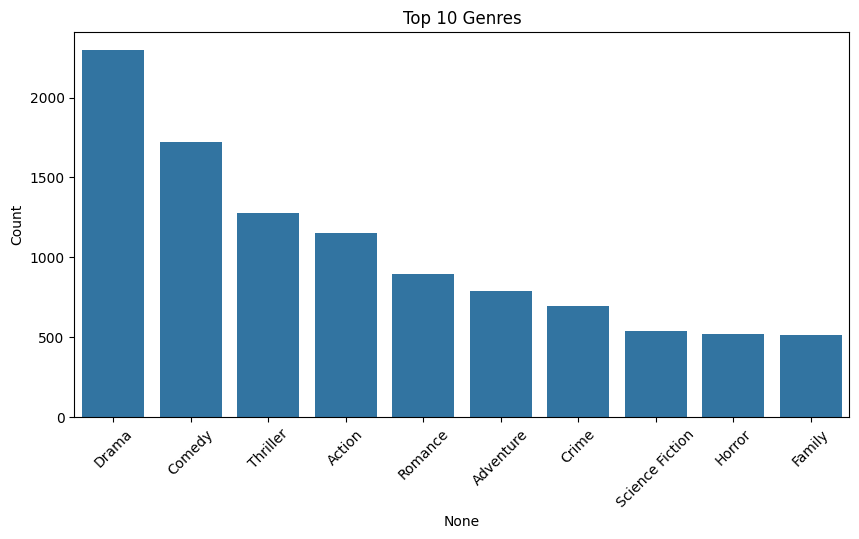

In [8]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

# Genre frequency
genre_list = sum(movies['genres'], [])
genre_freq = pd.Series(genre_list).value_counts()

plt.figure(figsize=(10,5))
sns.barplot(x=genre_freq[:10].index, y=genre_freq[:10].values)
plt.xticks(rotation=45)
plt.title("Top 10 Genres")
plt.ylabel("Count")
plt.show()


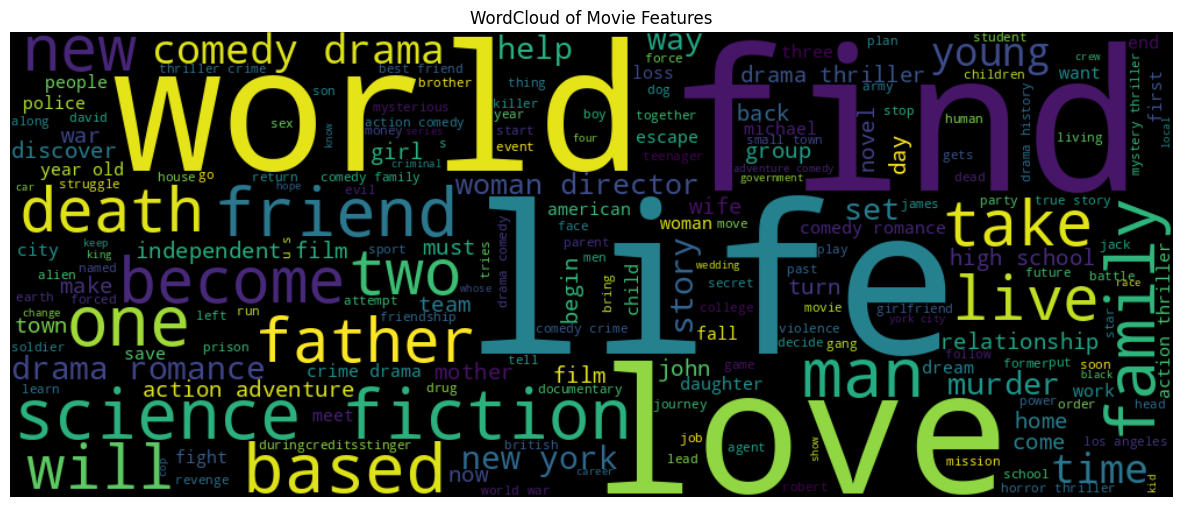

In [9]:
text = ' '.join(movies['tags'].values)
wordcloud = WordCloud(width=1000, height=400, background_color='black').generate(text)

plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of Movie Features")
plt.show()
